In [30]:
import sys
sys.path.insert(0, '../../../PyPlr')

import numpy as np
import pandas as pd

from pyplr.CIE import get_CIES026
from pyplr.oceanops import predict_dark_spds, calibrated_radiance

# Spectral sensitivities

<AxesSubplot:xlabel='index'>

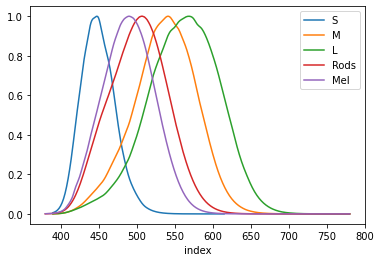

In [31]:
_ , sss = get_CIES026(asdf=True)
#sss = sss[::5] # downsample to 5nm bins
sss.plot()

# Get calibrated radiance data

In [47]:
oo_spectra = pd.read_csv('../data/oo_led_intensity_spectra_08-17-20-14-31.csv')
oo_info = pd.read_csv('../data/oo_led_intensity_info_08-17-20-14-31.csv')
oo_info.rename({'intensitiy':'intensity'}, inplace=True)

oo_dark_spds = predict_dark_spds(oo_info, '../data/oo_dark_cal.txt')

cal_per_wl = pd.read_csv('../data/oo_calibration.csv', header=None)
sensor_area_cm2 = pd.read_csv('../data/oo_sensorArea.csv', header=None)

wperm2pernm = calibrated_radiance(oo_spectra, oo_info, oo_dark_spds, cal_per_wl, sensor_area_cm2)
wperm2pernm

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,2.469001e-09,2.863411e-09,2.462993e-09,2.708239e-09,2.226493e-09,2.356718e-09,2.228330e-09,2.205411e-09,2.269472e-09,2.643924e-09,...,1.571073e-09,1.862064e-09,1.769685e-09,1.580814e-09,1.684430e-09,1.654450e-09,1.635425e-09,1.412584e-09,1.707972e-09,1.758867e-09
1,1.652756e-09,1.671725e-09,1.536763e-09,1.680989e-09,1.449702e-09,1.502447e-09,1.526559e-09,1.370141e-09,1.525867e-09,1.813022e-09,...,8.419718e-10,1.026987e-09,9.139263e-10,8.905806e-10,9.617285e-10,9.418015e-10,8.804135e-10,7.481551e-10,9.604163e-10,9.642558e-10
2,2.126946e-09,2.186599e-09,2.045235e-09,2.147118e-09,1.846258e-09,1.828590e-09,1.961884e-09,1.687823e-09,1.882032e-09,2.121223e-09,...,1.324427e-09,1.537786e-09,1.508286e-09,1.249684e-09,1.464148e-09,1.490818e-09,1.168833e-09,1.100160e-09,1.264143e-09,1.537414e-09
3,4.859725e-09,4.824625e-09,4.599880e-09,4.789661e-09,4.013954e-09,4.257084e-09,4.593306e-09,3.744664e-09,3.959948e-09,4.740110e-09,...,6.393926e-09,6.828937e-09,6.488559e-09,6.238818e-09,6.484574e-09,6.190939e-09,5.928776e-09,5.647246e-09,5.892353e-09,6.110995e-09
4,3.294328e-09,3.668194e-09,3.252705e-09,3.488545e-09,2.823211e-09,2.714850e-09,3.055322e-09,2.770745e-09,2.940622e-09,3.458598e-09,...,2.398975e-09,2.730383e-09,2.515103e-09,2.363225e-09,2.609875e-09,2.605422e-09,2.378907e-09,2.264590e-09,2.611840e-09,2.720701e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.492841e-09,1.545434e-09,1.488709e-09,1.525293e-09,1.311324e-09,1.262182e-09,1.473675e-09,1.385454e-09,1.437785e-09,1.582553e-09,...,7.761266e-10,8.376219e-10,8.361505e-10,8.257374e-10,9.155074e-10,9.043659e-10,8.077186e-10,6.837819e-10,8.640401e-10,8.849775e-10
636,1.907704e-09,2.082279e-09,1.850609e-09,2.007225e-09,1.749484e-09,1.823612e-09,1.928247e-09,1.739366e-09,1.898096e-09,2.065599e-09,...,1.048145e-09,1.180928e-09,1.086584e-09,1.045963e-09,1.181097e-09,1.202441e-09,1.016072e-09,9.250529e-10,1.140812e-09,1.156148e-09
637,2.204976e-09,2.437277e-09,2.211612e-09,2.308595e-09,2.010853e-09,2.045135e-09,2.179840e-09,2.041813e-09,2.193963e-09,2.330677e-09,...,1.360513e-09,1.631179e-09,1.558838e-09,1.386445e-09,1.561687e-09,1.449022e-09,1.391023e-09,1.211719e-09,1.548028e-09,1.608219e-09
638,3.995458e-09,4.140244e-09,3.847322e-09,3.985331e-09,3.491893e-09,3.349727e-09,3.641669e-09,3.139744e-09,3.491781e-09,3.866658e-09,...,5.139980e-09,5.286546e-09,5.040271e-09,4.833871e-09,5.082289e-09,4.843944e-09,4.669180e-09,4.504396e-09,4.690470e-09,4.832578e-09


In [48]:
wperm2pernm['led'] = oo_info['led']
wperm2pernm['intensity'] = oo_info['intensitiy']
wperm2pernm.set_index(['led', 'intensity'], inplace=True)
wperm2pernm.sort_index(inplace=True)
wperm2pernm

0             1             2             3    \
led intensity                                                           
0   0          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    65         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    130        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    195        1.274430e-10  1.271003e-10  1.117038e-10  1.189514e-10   
    260        3.994966e-10  3.865349e-10  3.751514e-10  3.811356e-10   
...                     ...           ...           ...           ...   
9   3835       9.215881e-09  8.968712e-09  8.430878e-09  8.333391e-09   
    3900       8.353998e-09  9.142260e-09  8.350415e-09  8.361165e-09   
    3965       8.766332e-09  8.645201e-09  8.813964e-09  8.827061e-09   
    4030       8.629516e-09  9.582889e-09  8.158349e-09  8.985121e-09   
    4095       8.885433e-09  9.398719e-09  8.668064e-09  8.923466e-09   

                        4             5             6             7    \
led intensity                                                           
0   0          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    65         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    130        0.000000e+00  9.527019e-12  0.000000e+00  8.643258e-12   
    195        1.139817e-10  1.186374e-10  1.093796e-10  1.345993e-10   
    260        3.550825e-10  3.497608e-10  3.848209e-10  3.411490e-10   
...                     ...           ...           ...           ...   
9   3835       7.838305e-09  7.556026e-09  8.388268e-09  7.255656e-09   
    3900       7.723487e-09  7.179358e-09  7.940092e-09  6.841304e-09   
    3965       7.178358e-09  7.428492e-09  8.030819e-09  7.286424e-09   
    4030       7.746231e-09  7.261899e-09  8.060465e-09  6.798632e-09   
    4095       7.751480e-09  6.927962e-09  7.818890e-09  6.798632e-09   

                        8             9    ...           391           392  \
led intensity                              ...                               
0   0          0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
    65         0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
    130        7.302424e-13  0.000000e+00  ...  0.000000e+00  0.000000e+00   
    195        1.220704e-10  1.338309e-10  ...  6.965899e-11  6.860214e-11   
    260        3.542661e-10  4.041398e-10  ...  2.164080e-10  2.220011e-10   
...                     ...           ...  ...           ...           ...   
9   3835       7.281539e-09  8.133598e-09  ...  5.633657e-09  6.743297e-09   
    3900       7.456969e-09  8.103841e-09  ...  6.050678e-09  6.945825e-09   
    3965       7.352293e-09  8.336707e-09  ...  6.053248e-09  6.694314e-09   
    4030       7.434301e-09  8.186600e-09  ...  6.073845e-09  6.929539e-09   
    4095       7.708316e-09  9.003327e-09  ...  5.924315e-09  6.879889e-09   

                        393           394           395           396  \
led intensity                                                           
0   0          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    65         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    130        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    195        6.251030e-11  6.816337e-11  5.077750e-11  6.094341e-11   
    260        2.139641e-10  1.977525e-10  2.108535e-10  2.158628e-10   
...                     ...           ...           ...           ...   
9   3835       6.553416e-09  6.065021e-09  6.444051e-09  6.540709e-09   
    3900       6.450195e-09  6.023478e-09  6.584602e-09  6.674317e-09   
    3965       6.212505e-09  5.761913e-09  6.615218e-09  6.500658e-09   
    4030       6.358719e-09  5.805747e-09  6.653118e-09  6.569742e-09   
    4095       6.488542e-09  5.867891e-09  6.739627e-09  6.635421e-09   

                        397           398           399           400  
led intensity                                                          
0   0          